In [1]:
# Parameters
run_number = 8


/home/ubuntu/miniconda3/envs/gnn_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train: 2400,Val: 800,Test: 882,Val + Train combined: 3200

Data loading completed



Hyperparameter optimization...



{'hidden_dim': 180, 'dropout_rate': 0.25178595398029424, 'aggregator_type': 'gcn', 'lr': 6.896393549062899e-06, 'batch_size': 256, 'n_hidden_layers': 1, 'lr_scheduler': 'StepLR', 'activation': 'LeakyRELU', 'step_size': 4, 'gamma_step': 0.6514389638382123}
Dataloaders done.
Retraining using best parameters...
Number of available node features (in_feats): 74


/tmp/ipykernel_1177575/2523736974.py:201: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()       # initializing the gradient scaler
/tmp/ipykernel_1177575/2523736974.py:215: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():    # automatically selects the appropriate floating-point precision (to optimize performance - speeds up training, reduces memory usage)
/home/ubuntu/miniconda3/envs/gnn_project/lib/python3.10/site-packages/dgl/backend/pytorch/sparse.py:157: FutureWarning: `torch.cuda.amp.autocast_mode._cast(value, dtype)` is deprecated. Please use `torch.amp.autocast_mode._cast(value, 'cuda', dtype)` instead.
  return th.cuda.amp.autocast_mode._cast(
/home/ubuntu/miniconda3/envs/gnn_project/lib/python3.10/site-packages/dgl/backend/pytorch/sparse.py:148: FutureWarning: `torch.cuda.amp.autocas

/tmp/ipykernel_1177575/2523736974.py:247: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():    # automatically selects the appropriate floating-point precision (to optimize performance - speeds up training, reduces memory usage)


Epoch 1/1000Train loss: 0.6971Val loss: 0.6970Val accuracy: 3.75% MCC: 0


Epoch 5/1000Train loss: 0.6970Val loss: 0.6966Val accuracy: 3.75% MCC: 0


Epoch 10/1000Train loss: 0.7005Val loss: 0.6962Val accuracy: 3.75% MCC: 0


Epoch 15/1000Train loss: 0.6993Val loss: 0.6959Val accuracy: 3.75% MCC: 0


Epoch 20/1000Train loss: 0.6985Val loss: 0.6958Val accuracy: 3.75% MCC: 0


Epoch 25/1000Train loss: 0.6970Val loss: 0.6958Val accuracy: 3.75% MCC: 0


Epoch 30/1000Train loss: 0.6973Val loss: 0.6957Val accuracy: 3.75% MCC: 0


Epoch 35/1000Train loss: 0.6975Val loss: 0.6957Val accuracy: 3.75% MCC: 0


Epoch 40/1000Train loss: 0.6969Val loss: 0.6957Val accuracy: 3.75% MCC: 0


Epoch 45/1000Train loss: 0.6996Val loss: 0.6957Val accuracy: 3.75% MCC: 0


Epoch 50/1000Train loss: 0.6990Val loss: 0.6957Val accuracy: 3.75% MCC: 0


Epoch 55/1000Train loss: 0.6954Val loss: 0.6957Val accuracy: 3.75% MCC: 0


Epoch 60/1000Train loss: 0.7041Val loss: 0.6957Val accuracy: 3.75% MCC: 0


Epoch 65/1000Train loss: 0.6986Val loss: 0.6957Val accuracy: 3.75% MCC: 0


Epoch 70/1000Train loss: 0.6977Val loss: 0.6956Val accuracy: 3.75% MCC: 0


Epoch 75/1000Train loss: 0.6970Val loss: 0.6956Val accuracy: 3.75% MCC: 0


Epoch 80/1000Train loss: 0.6966Val loss: 0.6956Val accuracy: 3.75% MCC: 0


Epoch 85/1000Train loss: 0.6985Val loss: 0.6956Val accuracy: 3.75% MCC: 0


Epoch 90/1000Train loss: 0.6995Val loss: 0.6956Val accuracy: 3.75% MCC: 0


Early stopping triggered at epoch 93
The best epoch was 13
Training done.
Final training...


Training done.
Evaluating on test_dataset


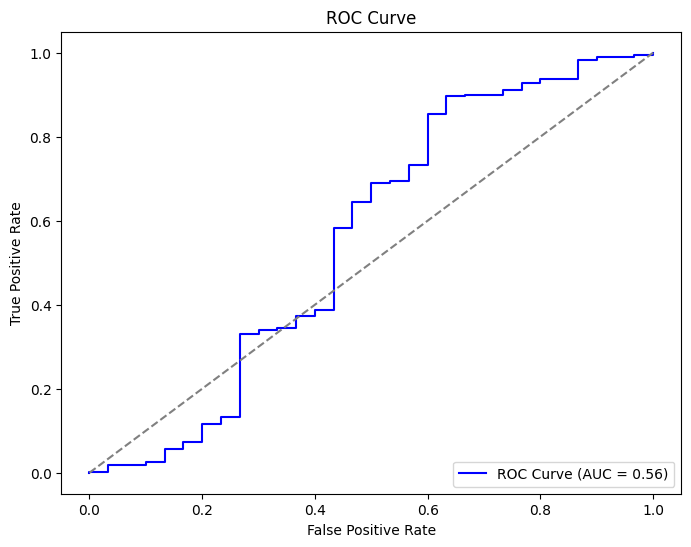

Test Loss: 0.6899791657924652
Accuracy: 0.9659863945578231, Precision: 0.9659863945578231, Recall: 1.0, F1-Score: 0.9826989619377162, MCC: 0.0, ROC-AUC: 0.5593896713615023
Evaluation done.


<Figure size 640x480 with 0 Axes>

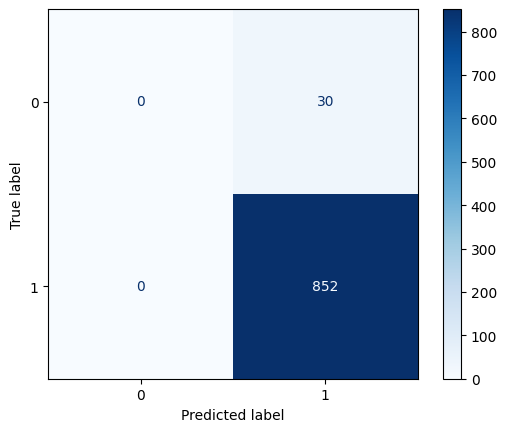

In [2]:


import math
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
torch.use_deterministic_algorithms(True)
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR, StepLR, ReduceLROnPlateau, CosineAnnealingLR
torch._dynamo.config.suppress_errors = True
import random

import json
import sys

import dgl
from dgl.nn import SAGEConv, GlobalAttentionPooling
from dgl.dataloading import GraphDataLoader
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import pandas as pd

import optuna
from optuna.pruners import MedianPruner
# subclass of torch.nn.Module

# subclass of torch.nn.Module



class SAGE(nn.Module):
    def __init__(
        self, 
        in_feats,       # input feature dimensions (anotation size)
        out_feats,    # the same thing as hidden_dim - number of dimentions of hi+1
        aggregator_type,    # type of aggregation
        dropout_rate=0.5, # the dropout rate 
        n_cls=0.2,
        n_hidden_layers=2,
        activation='RELU'
        ):
        super(SAGE, self).__init__()
        self.n_hidden_layers = n_hidden_layers
        self.dropout = nn.Dropout(dropout_rate) # dropout layer
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.n_cls = n_cls
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(n_hidden_layers):
            if i == 0:
                set_in_feats = self.in_feats
            else:
                set_in_feats = self.out_feats
            layer = SAGEConv(
                in_feats=set_in_feats,
                out_feats=out_feats,
                aggregator_type=aggregator_type,
                feat_drop=dropout_rate,
            )
            self.layers.append(layer)
        self.pooling = GlobalAttentionPooling(nn.Linear(self.out_feats, 1))
            # --> aggregating the features into a single graph-level representation
            # gate mechanism determines the importance of each node
        self.output_layer = nn.Linear(self.out_feats, n_cls)
        self.loss_fn = nn.CrossEntropyLoss()
    def forward(self, graph, labels):
        #feat = self.dropout(labels)
        if (self.activation == 'RELU'):
            h = F.relu(self.layers[0](graph, labels))
        elif (self.activation == 'LeakyRELU'):
            h = F.leaky_relu(self.layers[0](graph, labels), negative_slope=0.01)
        #h = F.relu(self.layers[0](graph, labels))
        h = self.dropout(h)
        for i in range(self.n_hidden_layers):
            # print(f"SHAPE OF h IS: {graph.ndata['h'].size()}")
            # print(f"NUM NODES: {graph.num_nodes()} ")
            if i == 0:
                continue
            else:
                if (self.activation == 'RELU'):
                    h = F.relu(self.layers[i](graph, h))
                elif (self.activation == 'LeakyRELU'):
                    h = F.leaky_relu(self.layers[i](graph, h), negative_slope=0.01)
                if i < self.n_hidden_layers - 1:
                    h = self.dropout(h)
        h = self.pooling(graph, h)#.squeeze
        h = self.output_layer(h)
        return h
    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            

class EarlyStopping():
    # implementing early stopping mechanism, but there is no printing method implemented
    """Early stops the training if neither validation loss nor validation
    accuracy improves after their respective patience levels.

    Parameters
    ----------
    patience_loss : int
        How long to wait after last time validation loss improved.
    patience_accuracy : int
        How long to wait after last time validation accuracy improved.
    verbose : bool
        If True, prints a message for each validation metric improvement.
    delta_loss : float
        Minimum change in the validation loss to qualify as an improvement.
    delta_accuracy : float
        Minimum change in the validation accuracy to qualify as an improvement.
    path : str
        The file path where the model will be saved.
    print_freq : int
        The frequency at which to print messages during training.

        - taken from Jozef's master's thesis
    """
    def __init__(
        self,
        patience_loss=10,
        patience_mcc=10,
        verbose=True,
        delta_loss=0.001,
        delta_mcc=0.001,
    ):
        self.patience_loss = patience_loss
        self.patience_mcc = patience_mcc
        self.verbose = verbose
        self.loss_counter = 0
        self.mcc_counter = 0
        self.best_loss = np.inf
        self.best_mcc = -1             # stores best accuracy so far
        self.early_stop = False             # bool indicating whether training should stop
        self.delta_mcc = 0.001
        self.delta_loss = 0.001
        self.best_epoch = 0

    # in this method, we are monitoring both the validation loss and accuracy
    def __call__(self, val_loss, val_acc, val_mcc, model, epoch):   # earlier the method was called '__step__'
        improved_loss = False
        improved_mcc = False

        if val_loss < self.best_loss - self.delta_loss:     # True only if val_loss improves beyond best_loss - delta_loss (treshold)
            self.best_loss = val_loss                           # delta_loss is a small treshold, which ought to prevent fluctuations
            self.loss_counter = 0                               # in the documentation implementation, there is a strict comparison without taking into account the fluctuations
            improved_loss = True
        else:
            self.loss_counter += 1

        if val_mcc > self.best_mcc + self.delta_mcc: # True if val_accuracy improves bexond best_accuracy + delta_accuracy (treshold)
            self.best_mcc = val_mcc
            self.mcc_counter = 0
            improved_mcc = True
        else:
            self.mcc_counter += 1

        if improved_loss or improved_mcc:              # if one of the metrics improves, we save the state as a checkpoint
            self.save_checkpoint(model, val_loss, val_mcc, val_acc)
            self.best_epoch = epoch

        if self.loss_counter >= self.patience_loss and self.mcc_counter >= self.patience_mcc: #
            self.early_stop = True
            if self.verbose:
                print("Early stopping triggered")

    def save_checkpoint(self, model, val_loss, val_mcc, val_acc):   # we save the model when either the accuracy or loss improves
        torch.save(model.state_dict(), "sage_checkpoint.pt")
        if self.verbose:
            print(f"Checkpoint saved, mcc: {val_mcc}, loss: {val_loss}, accuracy: {val_acc}")

class Training:
    def __init__(self, device):
        self.device = device

    def train_and_evaluate(
        self,
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        early_stopping,
        num_epochs,
        # plot_curves=False,   for plotting curves
        accumulation_steps=2,
        scheduler="None"
    ):
        train_losses, val_losses = [], []
        scaler = GradScaler()       # initializing the gradient scaler
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            optimizer.zero_grad     # we initialize the gradients to zero, so that the gradients from the previous batch do not accumulate

            for batch_idx, (batched_graph, labels) in enumerate(train_loader):  # train_loader ... data loader probiding batches of data
                batched_graph, labels = batched_graph.to(self.device), labels.to(self.device)   # self.device ... typically CPU or GPU
                                                                                                # - by moving the data over there we ensure that both the data and the model are on the same device
                                                                                                # that ensures no errors and consistency
                batched_graph.ndata['h'] = batched_graph.ndata['h'].float().to(self.device) # Move node features to device - by bot TODO TODO TODO



                with autocast():    # automatically selects the appropriate floating-point precision (to optimize performance - speeds up training, reduces memory usage)
                    logits = model(batched_graph, batched_graph.ndata['h'].float()) # rund the model inside the autocast() context
                    loss = criterion(logits, labels) / accumulation_steps   # we are using the gradient accumulation, because the batch size is too big to fit in memory
                    # therefore we accumulate gradients over multiple batches before we update the weight --> loss is scaled down by the number of accumulation steps
                scaler.scale(loss).backward()   # scaling the loss, preventing very small gradients from becoming zero (common issue in mixed precission training (autocast)
                                                # .backward - computing the gradient using backpropagation
                train_loss += loss.item() * accumulation_steps  # .item() ... converts loss from tensor to a python float
                # we multiply by accumulation_steps to scale it back (we scaled down/divided earlier)
                if (batch_idx + 1) % accumulation_steps == 0 or batch_idx == len(train_loader) - 1: # accumulating gradients for multiple batches before updatiing the model
                # update does not happen after every batch
                    scaler.step(optimizer)  # applying the scaled gradients to update model parameters
                    scaler.update()         # ... updates the scaling factor for the next iteration
                    # dynamically adjusts the scaling value to mantain stable gradients - if gradients too small, increases the scale and vice versa
                    optimizer.zero_grad()   # initializing gradients to zero - clearing the gradients before the next batch

            train_loss = train_loss/len(train_loader)   # getting the average loss per batch
            train_losses.append(train_loss)

            validation_loss = 0.0
            validation_accuraccy = 0.0
            num_val_correct = 0         # number of correctly predicted samples
            num_total = 0               # total number of samples
            TP, TN, FP, FN = 0, 0, 0, 0
            if val_loader is not None:  # val_loader ... validation dataset, we check, whether it is not null --> then there would be no validation
                model.eval()            # we put the model into the evaluation mode - we turn off the dropout layers and disable the batch normalization updates
                                        # --> validation results are consistent and unaffected by randomness
                with torch.no_grad():   # we prevent pytorch from storing gradients during validation --> saves memory and improves performance
                    for batched_graph, labels in val_loader:        # iterates over mini-batches of validation data
                        batched_graph, labels = batched_graph.to(self.device), labels.to(self.device)   # we move the input and labels to the correct device (CPU, GPU)

                        batched_graph.ndata['h'] = batched_graph.ndata['h'].to(self.device) # TODO TODO TODO - chatova práce

                        with autocast():    # automatically selects the appropriate floating-point precision (to optimize performance - speeds up training, reduces memory usage)
                            logits = model(batched_graph, batched_graph.ndata['h'].float())
                            # graph structure (batched_graph) is passed on to the model, node features (batched_graph.ndata['h']) serve as input data
                                # --> The GNN layers aggregate information from neighboring nodes
                                # final layer outputs predictions (logits) for node/graph classification
                            loss = criterion(logits, labels)    # we compute the loss
                        validation_loss += loss             # accumulating loss over all batches
                        _, predicted = torch.max(logits.data, 1)    # getting the predicted class (highest probability)
                        num_total += labels.size(0)             # updating the total number of samples
                        num_val_correct += (predicted == labels).sum().item()   # adds up the number of correct predictions
                        TP += ((predicted == 1) & (labels == 1)).sum().item()
                        TN += ((predicted == 0) & (labels == 0)).sum().item()
                        FP += ((predicted == 1) & (labels == 0)).sum().item()
                        FN += ((predicted == 0) & (labels == 1)).sum().item()

                    num = TP * TN - FP * FN
                    den = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
                    validation_mcc = num / den if den > 0 else 0
                    validation_loss = validation_loss/len(val_loader)   # we get the average loss
                    val_losses.append(validation_loss)
                    validation_accuraccy = num_val_correct/num_total    # saving for early stopping
                    if early_stopping:  # checking if early stopping is not None
                        early_stopping(validation_loss, validation_accuraccy, validation_mcc, model, epoch + 1)
                        if early_stopping.early_stop:
                            print(f"Early stopping triggered at epoch {epoch + 1}")
                            break
                    if (epoch + 1) % 5 == 0 or epoch == 0:
                        print(f'Epoch {epoch + 1}/{num_epochs}'
                              f'Train loss: {train_loss:.4f}'
                              f'Val loss: {validation_loss:.4f}'
                              f'Val accuracy: {100 * validation_accuraccy:.2f}% '
                              f'MCC: {validation_mcc}')
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(validation_loss)
            elif scheduler is not None:  # using the scheduler
                scheduler.step()
                # plotting of curves might be implemented here (TODO)

        # there the plot curves method might be implemented (another TODO possibility)

    def evaluate_on_test(self, model, test_loader, criterion, run_id=1):
        model.eval()    # we put model into the evaluation model (ensuring that gradients won't be computed)
        test_loss = 0.0
        all_preds = []        # storing all predicted labels
        all_labels = []       # storing all labels (true labels)
        all_proba = []
        with torch.no_grad():       # disabling calculations of gradient
            for batched_graph, labels in test_loader:       # iterates over mini-batches of validation data
                batched_graph, labels = batched_graph.to(self.device), labels.to(self.device)       # we move the input and labels to the correct device (CPU, GPU)
                logits = model(batched_graph, batched_graph.ndata['h'].float())
                loss = criterion(logits, labels)
                test_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy()) # moving predictions and labels to CPU and converting them to NumPy arrays
                #all_labels.extend(preds.cpu().numpy()) # (they get stored in all_pred ad all_labels variables)
                all_labels.extend(labels.cpu().numpy())
                all_proba.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy()) 
                #all_proba
        test_loss = test_loss/len(test_loader)  # averages the total loss over all test batches
        # calculating evaluation metrics:
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        roc_auc = roc_auc_score(all_labels, all_preds)
        matthews_corr = matthews_corrcoef(all_labels, all_preds)
         # Compute ROC curve ---------
        fpr, tpr, _ = roc_curve(all_labels, all_proba)
        roc_auc = auc(fpr, tpr)
        # Plot ROC Curve --------
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        plt.savefig("sage_plot.png")

        # confusion matrix
        conf_mat = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
        disp.plot(cmap='Blues')
        plt.savefig("conf_mat_sage.png")
        # possible to save here (TODO) ?

        results_dataFrame = pd.DataFrame({
            'Test Loss': [test_loss],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'MCC': [matthews_corr],
            'ROC-AUC': [roc_auc]
        })
        results_dataFrame.to_csv('test_results_SAGE.csv')  # possible to adjust settings
        print(f"Test Loss: {test_loss}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, MCC: {matthews_corr}, ROC-AUC: {roc_auc}")

def collate(samples):   # converts individual graph samples into a single batch for training
                        # input ... samples - a list of tuples, where each tuple contains (graph, label)
                        # graph ... dgl graph object, label ... a target label
    graphs, labels = map(list, zip(*samples))   # unpacking graphs and labels from the list of tuples and converting them into separate lists
    batched_graph = dgl.batch(graphs)           # batching the graphs (sdružování grafů)
    labels = torch.tensor(labels, dtype=torch.long) # converting list of labels into a PyTorch tensor
    return batched_graph, labels
                        # batched graph ... single batched graph combining individual graphs
                        # labels ... tensor of labels for the batch

class Hyperparameter_optimizer:     # optuna ... library for automatic hyperparameter tuning, selecting the best hyperparameters based on validation loss
    def __init__(
        self,
        device,                     # GPU/CPU
        subset_train_graphs,        # training data (graphs + labels)
        subset_train_labels,
        subset_val_graphs,          # validation data (graphs + labels)
        subset_val_labels,
        num_trials,                 # number of trials for optimization
        num_epochs,                  # number of training epochs per trial
        random_state
    ):
        self.device = device        # setting all of the parameters of the class
        self.subset_train_graphs = subset_train_graphs
        self.subset_train_labels = subset_train_labels
        self.subset_val_graphs = subset_val_graphs
        self.subset_val_labels = subset_val_labels
        self.num_trials = num_trials
        self.num_epochs = num_epochs
        self.random_state = random_state
    def objective(self, trial):     # sample hyperparameters, optuna is doing a "smart" selection of hyperparameters, which are most likely to give the best result
        # optuna does not try all the combinations, since that would simply take too long
        in_feats = 74
        #hidden_dim = trial.suggest_int('hidden_dim', 74, 256)
        hidden_dim = trial.suggest_int('hidden_dim', 177, 236)
        
        #dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.5)
        dropout_rate = trial.suggest_float('dropout_rate', 0.22, 0.30)
        
        #aggregator_type = trial.suggest_categorical('aggregator_type', ['mean', 'gcn', 'pool', 'lstm'])
        aggregator_type = trial.suggest_categorical('aggregator_type', ['gcn', 'pool'])
        
        #lr = trial.suggest_float('lr', 1e-6, 1e-1, log=True)
        lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
        
        #batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])#, 512])
        batch_size = trial.suggest_categorical('batch_size', [256])
        
        #n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 6)
        n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 5)
        
        #lr_scheduler = trial.suggest_categorical('lr_scheduler', ['None', 'StepLR', 'ExponentialLR'])
        lr_scheduler = trial.suggest_categorical('lr_scheduler', ['None','StepLR'])
        
        #activation = trial.suggest_categorical('activation', ['RELU', 'LeakyRELU'])
        activation = trial.suggest_categorical('activation', ['LeakyRELU'])

        model = SAGE(              # initializing model with sampled hyperparameters
            in_feats=74,
            out_feats=hidden_dim,
            dropout_rate=dropout_rate,
            aggregator_type=aggregator_type,
            n_cls=2,
            n_hidden_layers=n_hidden_layers,
            activation = activation             # set differently?? TODO TODO TODO
        #)      TODO TODO TODO - this is where the model is moved to the device (written by bot)
        ).to(self.device)
        
        class_counts = np.bincount(self.subset_train_labels)
        class_counts[class_counts == 0] = 1
        class_weights = 1.0 / class_counts
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=lr)   # using Adam optimizer
        #criterion = nn.CrossEntropyLoss().to(self.device)   # criterion for the classification task
        criterion = nn.CrossEntropyLoss(weight=class_weights).to(self.device)   # criterion for the classification task
        # creating Dataloaders for training and validation - batches graphs and labels for training & validation
            # Dataloaders in dgl ... handles graphs instead of regular tensors, creates mini-batches for efficient training, allows parallel processing, ...
                                    # schuffles training data to prevent bias
        scheduler_obj = None
        if lr_scheduler == 'None':
            scheduler_obj = None
        elif lr_scheduler == 'StepLR':
            #step_size = trial.suggest_int('step_size', 3, 6)
            #step_size = trial.suggest_int('step_size', 15, 19)
            step_size = trial.suggest_int('step_size', 4, 5)
            #gamma_step = trial.suggest_float('gamma_step', 0.5, 0.99)
            gamma_step = trial.suggest_float('gamma_step', 0.62, 0.75)
            scheduler_obj = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma_step)
        elif lr_scheduler == 'ExponentialLR':
            gamma_exp = trial.suggest_float('gamma_exp', 0.1, 0.99)
            #gamma_exp = trial.suggest_float('gamma_exp', 0.13, 0.5)
            scheduler_obj = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma_exp)    
            
        train_loader = GraphDataLoader(
            list(zip(self.subset_train_graphs, self.subset_train_labels)),
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate,         # custom function for combining graphs into batches
            num_workers=0)                            # debugging TODO TODO TODO
            #num_workers=8)  # debugging TODO TODO TODO
        val_loader = GraphDataLoader(
            list(zip(self.subset_val_graphs, self.subset_val_labels)),
            batch_size=batch_size,
            shuffle=False,              # we do not want to schuffle the data - we want them fixed for consistency
            collate_fn=collate,
            num_workers=0)
            #num_workers=8)

                          # we set the model into the training mode, but do not do the training itself --> therefore the following function
        for epoch in range(self.num_epochs):    # training the model
            model.train() 
            for batched_graph, labels in train_loader:
                batched_graph, labels = batched_graph.to(self.device), labels.to(self.device)   # moving graphs and labels into the device CPU/GPU
                batched_graph.ndata['h'] = batched_graph.ndata['h'].to(self.device) # TODO TODO TODO - chatova práce
                optimizer.zero_grad()
                logits = model(batched_graph, batched_graph.ndata['h'].float())     # this line calls the model's forward pass using two inputs
                        # batched graph ... graph structure containing connectivity information
                        # second argument ... node features extracted from the graph, converted to floating point numbers
                loss = criterion(logits, labels)
                loss.backward()     # we calculated loss and we backpropagate the gradients
                optimizer.step()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batched_graph, labels in val_loader:
                    batched_graph, labels = batched_graph.to(self.device), labels.to(self.device)
                    batched_graph.ndata['h'] = batched_graph.ndata['h'].to(self.device) # TODO TODO TODO - chatova práce
                    optimizer.zero_grad()
                    logits = model(batched_graph, batched_graph.ndata['h'].float())
                    loss = criterion(logits, labels)
                    val_loss += loss.item()

            val_loss = val_loss/len(val_loader)
            trial.report(val_loss, epoch)       # we use this line to report the current validation loss at a given epoch for the ongoing trial
                                                    # optuna is collecting these intermediates results, optuna can then stop the non-promising trials early
            if lr_scheduler != 'None':  # using the scheduler
                scheduler_obj.step()
            if trial.should_prune():            # asking optuna, if trial should be pruned ("ended")
                raise optuna.TrialPruned()  # TODO TODO
        return val_loss

    def optimize(self):     # running the whole hyperparameter optimization using optuna
        sampler = optuna.samplers.TPESampler(seed=self.random_state)
        study = optuna.create_study(direction='minimize', pruner=MedianPruner(), sampler=sampler)
            # Medianpruner ... stops unpromising trials based on the median performance so far
        study.optimize(self.objective, n_trials=self.num_trials, n_jobs=1)  # running optimization process, specifies, how many different sets of hyperparameters (different trials) to try
        best_hyperparameters = study.best_trial.params
        with open(f'sage_best_hyperparams.json', 'w') as f:    # saving the trials into a JSON file
            json.dump(best_hyperparameters, f)
        print(f"Best hyperparameters are {best_hyperparameters}.")  # printing the best hyperparameters
        top_trials = sorted(study.trials, key=lambda t: t.value)[:10]

        for i, trial in enumerate(top_trials, 1):
            print(f"\nTrial #{i}")
            print(f"  Value (Objective): {trial.value}")
            print(f"  Params: {trial.params}")





def data_loading(address_train, address_val, address_test, RANDOM_STATE, part=1):
    train_graphs, train_labels_dictionary = dgl.load_graphs(address_train)
    train_labels = train_labels_dictionary['labels']
    train_labels = train_labels.squeeze()
    train_labels = train_labels.numpy()

    val_graphs, val_labels_dictionary = dgl.load_graphs(address_val)
    val_labels = val_labels_dictionary['labels']
    val_labels = val_labels.squeeze()
    val_labels = val_labels.numpy()

    test_graphs, test_labels_dictionary = dgl.load_graphs(address_test)
    test_labels = test_labels_dictionary['labels']
    test_labels = test_labels.squeeze()
    test_labels = test_labels.numpy()

    subset_train_indices = np.random.choice(
        len(train_graphs), size=int(len(train_graphs) * 0.2), replace=False # we choose 20% of the training graphs
    )   # replace=False ensures that no index is selected more than once

    subset_train_graphs = [train_graphs[i] for i in subset_train_indices] # we store the corresponding graphs
    subset_train_labels = train_labels[subset_train_indices]    # we store the corresponding labels

    subset_val_indices = np.random.choice(
        len(val_graphs), size=int(len(val_graphs) * 0.2), replace=False
    )
    subset_val_graphs = [train_graphs[i] for i in subset_val_indices]
    subset_val_labels = val_labels[subset_val_indices]

    combined_train_graphs = train_graphs + val_graphs # + ... list concatenation, two lists are merged into one
    combined_train_labels = np.concatenate((train_labels, val_labels))  # two arrays merged into one

    graphs = combined_train_graphs + test_graphs
    labels_numpy = np.concatenate((combined_train_labels, test_labels))

    print(
        f'Train: {len(train_graphs)},'
        f'Val: {len(val_graphs)},'
        f'Test: {len(test_graphs)},'
        f'Val + Train combined: {len(combined_train_graphs)}'
    )
    print("\nData loading completed\n")
    sys.stdout.flush()
    return {
        "graphs": (graphs, labels_numpy),
        "train": (train_graphs, train_labels),
        "val": (val_graphs, val_labels),
        "test": (test_graphs, test_labels),
        "subset_train": (subset_train_graphs, subset_train_labels),
        "subset_val": (subset_val_graphs, subset_val_labels),
        "combined_train": (combined_train_graphs, combined_train_labels),
    }
    
def main_train_loop(run_number):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # TODO ?? what is cuda??
    RANDOM_STATE = 42
    # setting the random state:
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed_all(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)

    
    num_trials = 160
    num_epochs = 100
    tune_hyperparams = False
    split_num = run_number
    
    data = data_loading(f"A2AR_graphs/a2ar_graphs_train{split_num}.bin", 
                        f"A2AR_graphs/a2ar_graphs_val{split_num}.bin",
                        f"A2AR_graphs/a2ar_graphs_test{split_num}.bin", RANDOM_STATE, part=1)
    graphs,_ = data["graphs"]
    train_graphs, train_labels = data["train"]
    val_graphs, val_labels = data["val"]
    test_graphs, test_labels = data["test"]
    subset_train_graphs, subset_train_labels = data["subset_train"]
    subset_val_graphs, subset_val_labels = data["subset_val"]
    combined_train_graphs, combined_train_labels = data["combined_train"]
    

    print('Hyperparameter optimization...\n')
    sys.stdout.flush()

    if tune_hyperparams:
        optimizer = Hyperparameter_optimizer(
            device,
            subset_train_graphs = train_graphs,
            subset_train_labels = train_labels,
            subset_val_graphs = val_graphs,
            subset_val_labels = val_labels,
            #subset_train_graphs = subset_train_graphs,
            #subset_train_labels = subset_train_labels,
            #subset_val_graphs = subset_val_graphs,
            #subset_val_labels = subset_val_labels,
            #num_trials=200,
            num_trials=num_trials,
            #num_epochs=100)   # TODO TODO TODO DEBUGGING
            num_epochs=num_epochs,
            random_state=RANDOM_STATE)

        optimizer.optimize()
    
        print("Hyperparameter optimization done.")
        sys.stdout.flush()
        print("")

#def retrain_using_best_parameters(train_graphs, val_graphs, test_graphs):
    # we load the data using GraphDataLoader
    with open(f'sage_best_hyperparams.json', 'r') as f:
        best_hyperparameters = json.load(f)     # we load the best hyperparameters
    print(best_hyperparameters)
    train_loader = GraphDataLoader(
        list(zip(train_graphs, train_labels)),
        batch_size=best_hyperparameters['batch_size'],
        shuffle=True,
        collate_fn=collate,
        num_workers=0)
        #num_workers=8)
    val_loader = GraphDataLoader(
        list(zip(val_graphs, val_labels)),
        batch_size=best_hyperparameters['batch_size'],
        shuffle=False,
        collate_fn=collate,
        num_workers=0)
        #num_workers=8)
    test_loader = GraphDataLoader(
        list(zip(test_graphs, test_labels)),
        batch_size=best_hyperparameters['batch_size'],
        shuffle=False,
        collate_fn=collate,
        num_workers=0)
        #num_workers=8)
    combined_test_val_loader = GraphDataLoader(
        list(
            zip(
                combined_train_graphs, combined_train_labels
            )),
        batch_size=best_hyperparameters['batch_size'],
        shuffle=True,
        collate_fn=collate,
        num_workers=0)
        #num_workers=8)
    print("Dataloaders done.")
    print("Retraining using best parameters...")
    print(f"Number of available node features (in_feats): {graphs[0].ndata['h'].shape[1]}")  # Check available node features
    model = SAGE(              # initializing model with sampled hyperparameters
        in_feats=74,    # adjusting according to the dataset TODO TODO TODO !!!
        out_feats=best_hyperparameters['hidden_dim'],
        dropout_rate=best_hyperparameters['dropout_rate'],
        aggregator_type=best_hyperparameters['aggregator_type'],
        n_cls=2,
        n_hidden_layers=best_hyperparameters['n_hidden_layers'],
        activation = best_hyperparameters['activation']
    ).to(device)
    model.reset_parameters()    # reseting the parameters of the model before retraining
    
    class_counts = np.bincount(combined_train_labels)
    class_counts[class_counts == 0] = 1
    class_weights = 1.0 / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    optimizer = optim.Adam(model.parameters(), lr=best_hyperparameters['lr'])
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

    lr_scheduler = None
    if best_hyperparameters['lr_scheduler'] == 'None':
        lr_scheduler = None
    elif best_hyperparameters['lr_scheduler'] == 'StepLR':
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, best_hyperparameters['step_size'], best_hyperparameters['gamma_step'])
    elif best_hyperparameters['lr_scheduler'] == 'ExponentialLR':
         lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, best_hyperparameters['gamma_exp'])

    #early_stopping = EarlyStopping(patience_loss=10, patience_accuracy=10, verbose=False, delta_loss=0.001, delta_accuracy=0.001) - PUVODNI SETTING!
    early_stopping = EarlyStopping(patience_loss=80, patience_mcc=80, verbose=False, delta_loss=0.001, delta_mcc=0.001)
    training = Training(device)
    training.train_and_evaluate(
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        early_stopping,
        1000,
        #1000,                # Number of epochs TODO TODO TODO ... this one WAS 300, for debugging purposes 5
        scheduler=lr_scheduler
    )
    optimal_epoch = early_stopping.best_epoch
    print(f"The best epoch was {optimal_epoch}") 
    model.reset_parameters()    # before we train the model on test + val dataset, we reset all the parameters
    print("Training done.")
    print("Final training...")
    
    class_counts = np.bincount(combined_train_labels)
    class_counts[class_counts == 0] = 1
    class_weights = 1.0 / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparameters['lr'])
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    
    lr_scheduler = None
    if best_hyperparameters['lr_scheduler'] == 'None':
        lr_scheduler = None
    elif best_hyperparameters['lr_scheduler'] == 'StepLR':
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, best_hyperparameters['step_size'], best_hyperparameters['gamma_step'])
    elif best_hyperparameters['lr_scheduler'] == 'ExponentialLR':
         lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, best_hyperparameters['gamma_exp'])
    
    
    training.train_and_evaluate(
        model,
        combined_test_val_loader,
        None,
        optimizer,
        criterion,
        None,
        optimal_epoch,
        scheduler=lr_scheduler
    )
    torch.save(model.state_dict(), f'sage_model.pt')
    print("Training done.")
    print("Evaluating on test_dataset")
    training.evaluate_on_test(model, test_loader, criterion)
    print("Evaluation done.")


if __name__ == "__main__":
    # This ensures that multiprocessing works safely when used with PyTorch DataLoader
    import multiprocessing
    multiprocessing.set_start_method('spawn', force=True)  # Ensure spawn method is used for safe process spawning


    # odstranit!
    #run_number = 1
    main_train_loop(run_number)

    

